In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
batch_size = 32
img_height = 224
img_width = 224
lr_rate = 1e-3
lr_mode = 'cos'
epochs = 8
data_dir = pathlib.Path(r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold2\Train").with_suffix('')

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 509 files belonging to 6 classes.
Using 408 files for training.
Found 509 files belonging to 6 classes.
Using 101 files for validation.
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


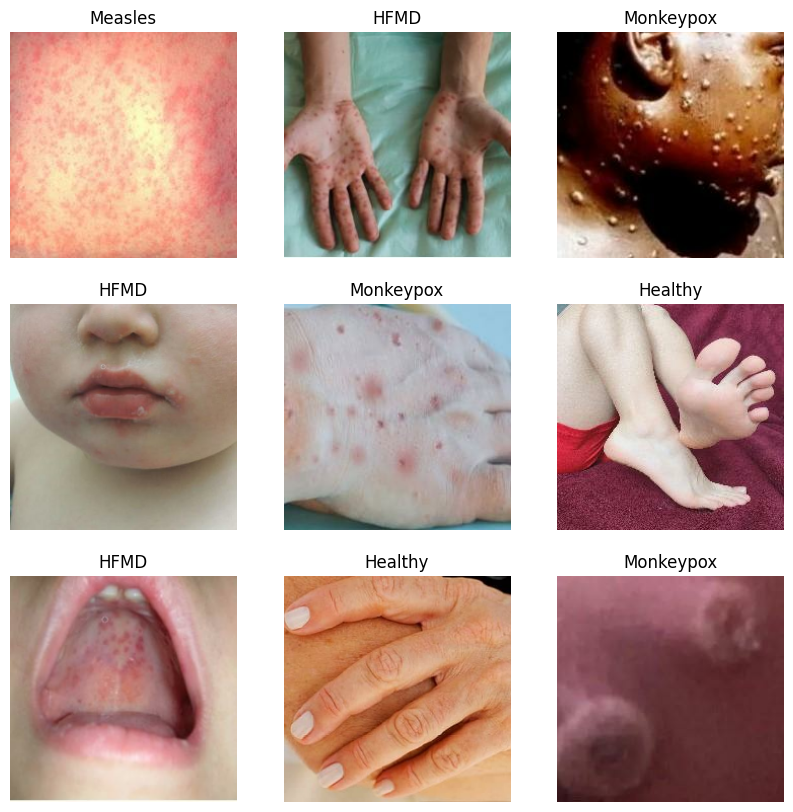

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [5]:
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(img_width, img_height, 3),
    include_top=False)

In [6]:
base_model.trainable = False

In [7]:
inputs = keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(6)(x)

model = keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,081,193 (38.46 MB)

 Trainable params: 6,031,622 (23.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
plot_model(
    model,
    to_file="resnet_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    dpi=96
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


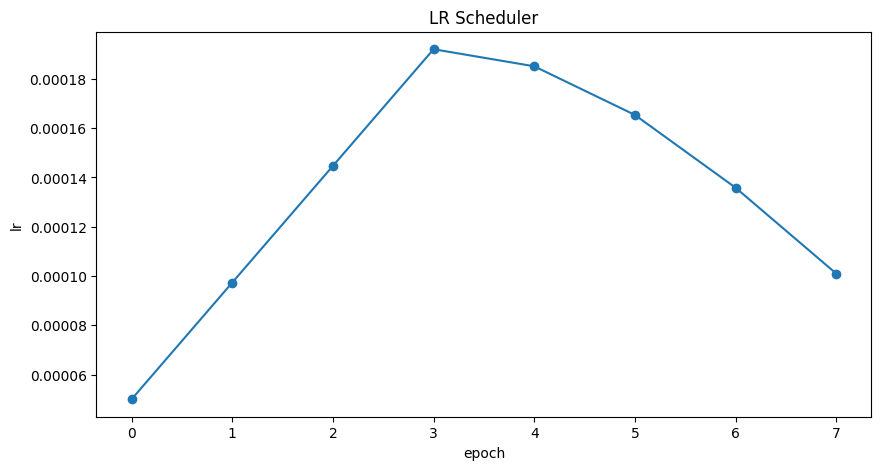

In [15]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback
lr_cb = get_lr_callback(batch_size, mode=lr_mode, plot=True, epochs=epochs)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=train_ds)


Epoch 1/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.3241 - loss: 1.5844 - val_accuracy: 0.6814 - val_loss: 1.0066 - learning_rate: 5.0000e-05
Epoch 2/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7365 - loss: 0.8355 - val_accuracy: 0.8407 - val_loss: 0.4958 - learning_rate: 9.7333e-05
Epoch 3/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8544 - loss: 0.4466 - val_accuracy: 0.9265 - val_loss: 0.2513 - learning_rate: 1.4467e-04
Epoch 4/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8963 - loss: 0.2768 - val_accuracy: 0.9877 - val_loss: 0.1152 - learning_rate: 1.9200e-04
Epoch 5/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9797 - loss: 0.1283 - val_accuracy: 0.9951 - val_loss: 0.0718 - learning_rate: 1.8507e-04
Epoch 6/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9853 - loss: 0.1001 - val_accuracy: 0.9951 - val_loss: 0.0472 - learning_rate: 1.6535e-04
Epoch 7/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9908 - loss: 0.0698

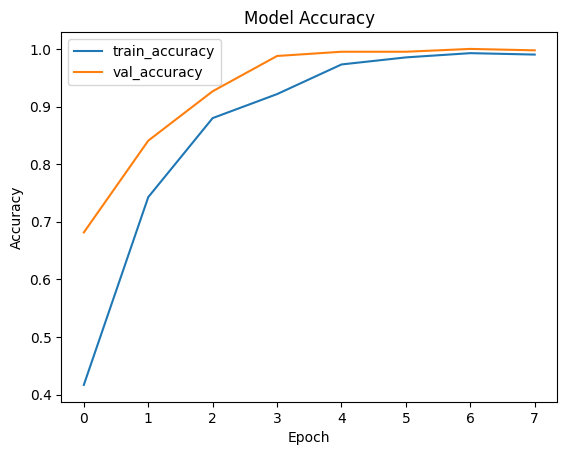

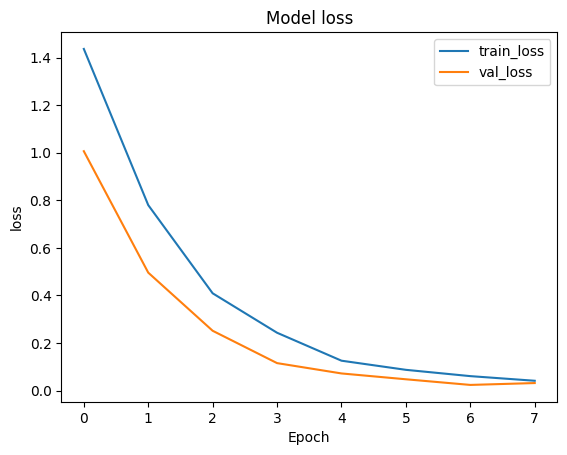

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [19]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 74 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step - accuracy: 0.9350 - loss: 0.2487


[0.2649613618850708, 0.9324324131011963]

In [20]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Valid"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 144 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 932ms/step - accuracy: 0.9407 - loss: 0.2474


[0.22950530052185059, 0.9444444179534912]

In [21]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold2\Valid"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 164 files belonging to 6 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step - accuracy: 0.7885 - loss: 0.7024


[0.643864631652832, 0.7865853905677795]

In [22]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold3\Valid"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 153 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 950ms/step - accuracy: 0.9013 - loss: 0.3502


[0.37434542179107666, 0.8888888955116272]

In [23]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold4\Valid"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


model.evaluate(test_ds)

Found 150 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 956ms/step - accuracy: 0.9462 - loss: 0.2025


[0.21818344295024872, 0.9466666579246521]

In [24]:
model.save('Efficientnet50_Mpox.keras')
!mkdir checkpoints

A subdirectory or file checkpoints already exists.


In [25]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
predictions =model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras

In [27]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.00      0.00      0.00        14
      Cowpox       0.25      0.22      0.24         9
        HFMD       0.26      0.26      0.26        31
     Healthy       0.17      0.18      0.17        22
     Measles       0.00      0.00      0.00        11
   Monkeypox       0.54      0.52      0.53        63

    accuracy                           0.31       150
   macro avg       0.20      0.20      0.20       150
weighted avg       0.32      0.31      0.32       150



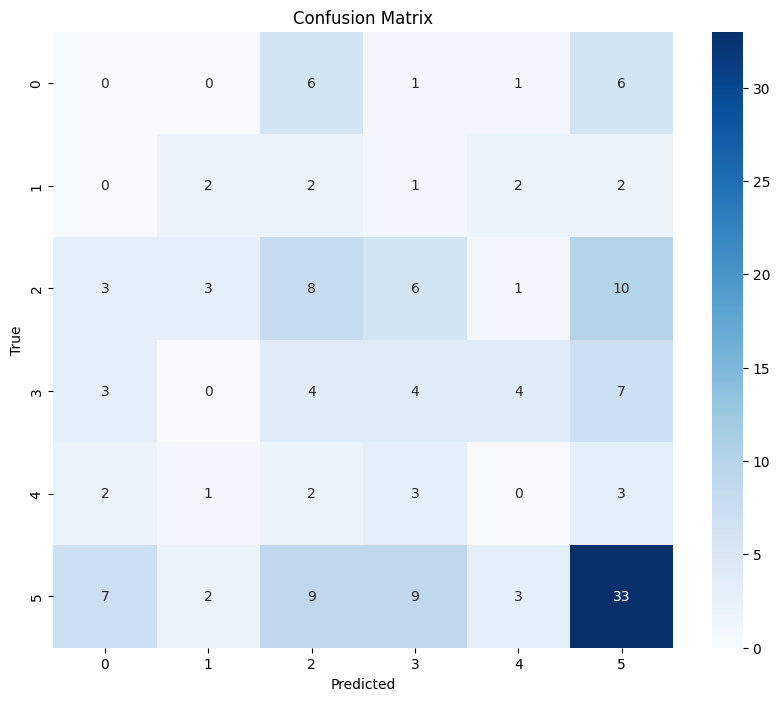

In [28]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [10]:
loaded_model = tf.keras.models.load_model(r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Efficientnet50_Mpox.keras", compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Prediction Function
def predict_image(image_path, model, class_names):
    img = load_img(image_path)
    img = img.resize((img_height, img_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    class_idx = np.argmax(y_pred, axis=1)[0]
    return class_names[class_idx]

In [12]:
# prediction on custom images

img_path1 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Chickenpox\CHP_19_01.jpg"    # Chickenpox
img_path2 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Healthy\HEALTHY_98_01.jpg" # Healthy
img_path3 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Measles\MSL_23_01.jpg" # Measles
img_path4 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Cowpox\CWP_09_01.jpg" # Cowpox

In [13]:
class_names = [
    'HFMD',
    'Monkeypox',
    'Measles',
    'Healthy',
    'Chickenpox',
    'Cowpox'
]
print('Predicted Class name:', predict_image(img_path1, model, class_names))
print('Predicted Class name:', predict_image(img_path2, model, class_names))
print('Predicted Class name:', predict_image(img_path3, model, class_names))
print('Predicted Class name:', predict_image(img_path4, model, class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class name: Measles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted Class name: Monkeypox
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted Class name: Measles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted Class name: Monkeypox
